In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from samwich.dataloaders import XarrayData
from samwich.waketrackers import track

# Identify "true" wake edges
- animate wake
- plot some metrics (e.g., vorticity) for sample snapshots

In [3]:
casedir = 'WAKEBENCH-NREL_DEBNATH_LES/neutral'
datafile = 'NREL_DEBNATH_LES_20190325_uvw_2D.nc'

In [4]:
method = 'ConstantArea'

In [5]:
Uref = 8.7 # m/s
D = 27.
zhub = 32.1
upstreamD = 2.5

In [6]:
Navg = 60

## Load data into wake object

In [7]:
Noffset = int(upstreamD*D / Uref)
Noffset

7

In [8]:
tslice = slice(Navg+Noffset-1, None)

In [9]:
xa = XarrayData(os.path.join(casedir,datafile),
                uvar='U',vvar='V',wvar='W',
                trim_time=tslice)

In [10]:
wo = track(xa.sliceI(), method=method, load3D=True)

Slicing data at i=0 x=54.0
Selected Tracker: ConstantArea

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 54.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1597

...finished initializing WakeTracker

...finished initializing ContourWakeTracker

...finished initializing ConstantArea 



## Animate plane

### instantaneous

Plot: frame 0

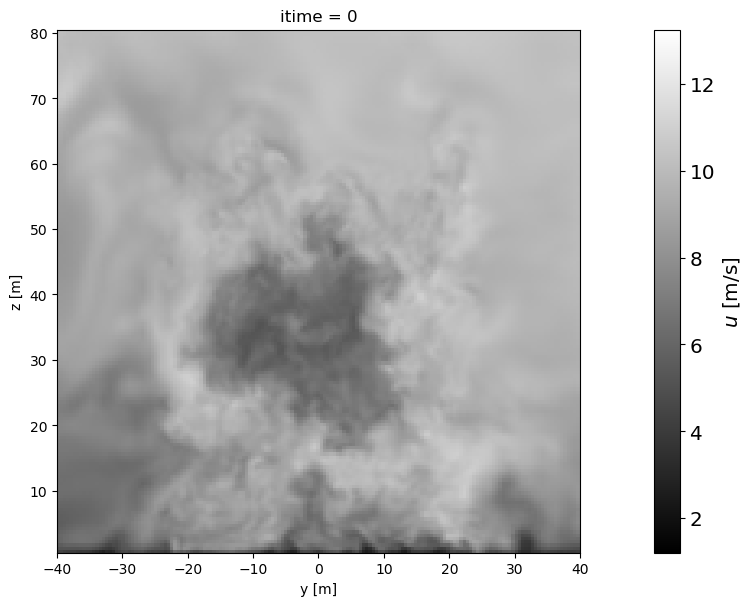

In [11]:
wplt = wo.plot()

### shear-removed

In [12]:
data = np.load(os.path.join(casedir,'inflow.npz'))

In [13]:
inflow = np.load(os.path.join(casedir,'inflow.npz'))

In [14]:
inflow['U'].shape

(1597, 162)

In [15]:
assert np.all(inflow['z'] == wo.xv[0,:])

In [16]:
wo.remove_shear(wind_profile=inflow['U'])

  subtracting out time-varying profile


## Check wake vorticity

In [17]:
# cell-centered streamwise velocity
U_cc = (wo.u_tot[:,1:  ,1:] +
        wo.u_tot[:, :-1,1:] +
        wo.u_tot[:,1:  ,:-1] +
        wo.u_tot[:, :-1,:-1]) / 4

In [18]:
# note: u.shape == (Ntimes, Ny, Nz)
dwdy = np.diff(wo.w, axis=1) / np.diff(wo.xh, axis=0)[np.newaxis,:,:]
dwdy = (dwdy[:,:,1:] + dwdy[:,:,:-1]) / 2

dvdz = np.diff(wo.v, axis=2) / np.diff(wo.xv, axis=1)[np.newaxis,:,:]
dvdz = (dvdz[:,1:,:] + dvdz[:,:-1,:]) / 2

dudy = np.diff(wo.u_tot, axis=1) / np.diff(wo.xh, axis=0)[np.newaxis,:,:]
dudy = (dudy[:,:,1:] + dudy[:,:,:-1]) / 2

dudz = np.diff(wo.u_tot, axis=2) / np.diff(wo.xv, axis=1)[np.newaxis,:,:]
dudz = (dudz[:,1:,:] + dudz[:,:-1,:]) / 2

In [19]:
# vorticity vector, neglecting d/dx components
vortx = dwdy - dvdz
vorty = dudz # - dwdx
vortz = -dudy # + dvdx
vort = np.sqrt(vortx**2 + vorty**2 + vortz**2)

Text(0.5, 1.0, 'normalized vorticity, $\\omega D/U_\\infty$')

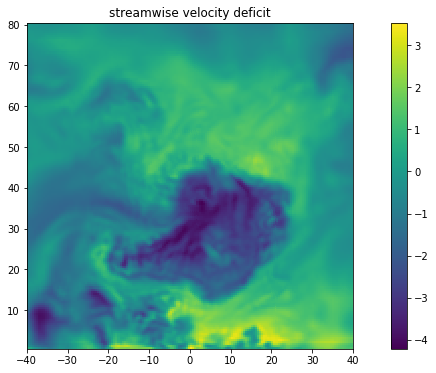

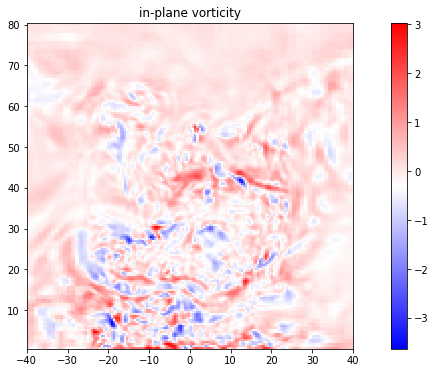

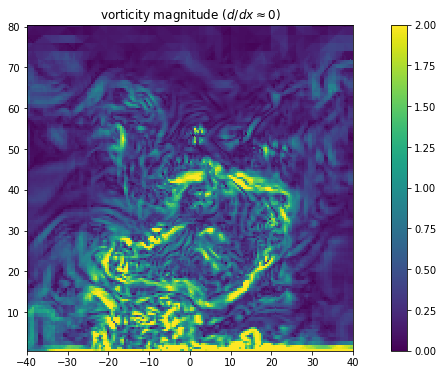

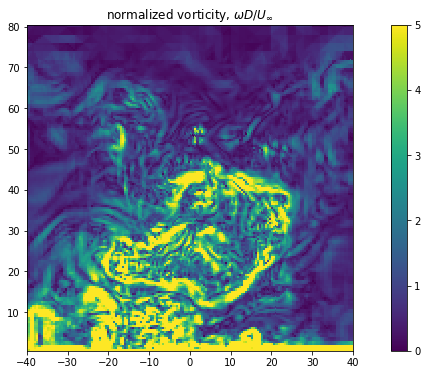

In [20]:
itime = 42

fig,ax = plt.subplots(figsize=(8,6))
cmsh = ax.pcolormesh(wo.xh,wo.xv,wo.u[itime,:,:])
fig.colorbar(cmsh)
ax.axis('scaled')
ax.set_title('streamwise velocity deficit')

fig,ax = plt.subplots(figsize=(8,6))
cmsh = ax.pcolormesh(wo.xh,wo.xv,vortx[itime,:,:],cmap='bwr')
fig.colorbar(cmsh)
ax.axis('scaled')
ax.set_title('in-plane vorticity')

fig,ax = plt.subplots(figsize=(8,6))
cmsh = ax.pcolormesh(wo.xh,wo.xv,vort[itime,:,:],vmin=0,vmax=2)
fig.colorbar(cmsh)
ax.axis('scaled')
ax.set_title(r'vorticity magnitude ($d/dx \approx 0$)')

fig,ax = plt.subplots(figsize=(8,6))
cmsh = ax.pcolormesh(wo.xh,wo.xv,vort[itime,:,:]*D/U_cc[itime,:,:],vmin=0,vmax=5)
fig.colorbar(cmsh)
ax.axis('scaled')
ax.set_title(r'normalized vorticity, $\omega D/U_\infty$')